In [ ]:
!pip install mujoco
!pip install mujoco_mjx
!pip install brax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 688.9/688.9 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 16.1 MB/s eta 0:00:00
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94505 sha256=f52cb7bf6c0524db4124e4851caec7036a27d46eaab05263d02f640444d27e9a
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b877907

In [ ]:
# 모듈 import
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
# mediapy 설치 확인 및 설치 (mediapy는 멀티미디어 파일을 다루는 Python 라이브러리)
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
# numpy 출력 설정 (배열 출력 시 소수점 이하 자릿수를 3자리로 제한, 과학적 표기법 사용 X, 한 줄에 출력되는 문자 수를 100자로 제한)
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.4 MB/s eta 0:00:00


In [ ]:
import functools
import jax
import os

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output

try:
  import brax
except ImportError:
  !pip install git+https://github.com/google/brax.git@main
  clear_output()
  import brax

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac

if 'COLAB_TPU_ADDR' in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

/usr/local/lib/python3.10/dist-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape
/usr/local/lib/python3.10/dist-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  PRNGKey = jax.random.KeyArray


In [ ]:
#@title Load Env { run: "auto" }

env_name = 'humanoid'  # @param ['ant', 'halfcheetah', 'hopper', 'humanoid', 'humanoidstandup', 'inverted_pendulum', 'inverted_double_pendulum', 'pusher', 'reacher', 'walker2d']
backend = 'positional'  # @param ['generalized', 'positional', 'spring']

env = envs.get_environment(env_name=env_name,
                           backend=backend)
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

HTML(html.render(env.sys, [state.pipeline_state]))

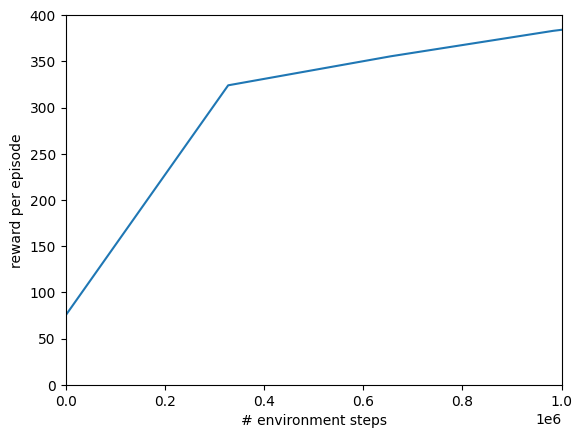

time to jit: 0:00:32.243295
time to train: 0:01:11.323183


In [ ]:
#@title Training

# 강화 학습 훈련 함수 설정 및 파라미터 전달
train_fn = {
  'humanoid': functools.partial(ppo.train,
                                num_timesteps=10_000_00,
                                num_evals=10,
                                reward_scaling=0.1,
                                episode_length=100,
                                normalize_observations=True,
                                action_repeat=1,
                                unroll_length=10,
                                num_minibatches=32,
                                num_updates_per_batch=8,
                                discounting=0.97,
                                learning_rate=3e-4,
                                entropy_cost=1e-3,
                                num_envs=2048,
                                batch_size=1024,
                                seed=1),
}[env_name]


max_y = {'humanoid': 400}[env_name]
min_y = {'reacher': -100, 'pusher': -150}.get(env_name, 0)

xdata, ydata = [], []
times = [datetime.now()]

def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  clear_output(wait=True)
  plt.xlim([0, train_fn.keywords['num_timesteps']])
  plt.ylim([min_y, max_y])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.plot(xdata, ydata)
  plt.show()

make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] -ㄴ times[1]}')

In [ ]:
model.save_params('/tmp/params', params)
params = model.load_params('/tmp/params')
inference_fn = make_inference_fn(params)

In [ ]:
#@title Visualizing a trajectory of the learned inference function

# create an env with auto-reset
env = envs.create(env_name=env_name, backend=backend)

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  act, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_env_step(state, act)

HTML(html.render(env.sys.replace(dt=env.dt), rollout))